In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf
from keras import backend as k
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
import os
import sklearn
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

In [4]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.12.0


In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
    print("on TPU")
except tf.errors.NotFoundError:
    print("not on TPU")
    strategy = tf.distribute.MirroredStrategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [5]:
tf.config.run_functions_eagerly(True)

In [6]:
tf.data.experimental.enable_debug_mode()

In [7]:
def multi_unet_model(IMG_SIZE,IMG_CHANNELS,N_CLASSES, activation_ ):
    IMG_HEIGHT,IMG_WIDTH = IMG_SIZE

  ###INPUT###

    inputs = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
#     s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  ###ENCODING LAYER###

    c1 = tf.keras.layers.Conv2D(8,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(8,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c1)
    p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

    c2 = tf.keras.layers.Conv2D(8*2,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(8*2,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c2)
    p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

    c3 = tf.keras.layers.Conv2D(8*4,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(p2)
    c3 = tf.keras.layers.Dropout(0.1)(c3)
    c3 = tf.keras.layers.Conv2D(8*4,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c3)
    p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

    c4 = tf.keras.layers.Conv2D(8*8,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(p3)
    c4 = tf.keras.layers.Dropout(0.1)(c4)
    c4 = tf.keras.layers.Conv2D(8*8,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c4)
    p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

    c5 = tf.keras.layers.Conv2D(8*16,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(p4)
    c5 = tf.keras.layers.Dropout(0.1)(c5)
    c5 = tf.keras.layers.Conv2D(8*16,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c5)

  ##DECODING LAYER###

    c6 = tf.keras.layers.Conv2DTranspose(8*8,(2,2),strides = (2,2),padding = 'same')(c5)
    c6 = tf.keras.layers.concatenate([c6,c4])
    c6 = tf.keras.layers.Conv2D(8*8,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(c6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(8*8,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c6)

    c7 = tf.keras.layers.Conv2DTranspose(8*4,(2,2),strides = (2,2),padding = 'same')(c6)
    c7 = tf.keras.layers.concatenate([c7,c3])
    c7 = tf.keras.layers.Conv2D(8*4,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(c7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(8*4,(3,3),activation =activation_, kernel_initializer='he_normal',padding = 'same')(c7)

    c8 = tf.keras.layers.Conv2DTranspose(8*2,(2,2),strides = (2,2),padding = 'same')(c7)
    c8 = tf.keras.layers.concatenate([c8,c2])
    c8 = tf.keras.layers.Conv2D(8*2,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(c8)
    c8 = tf.keras.layers.Dropout(0.2)(c8)
    c8 = tf.keras.layers.Conv2D(8*2,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c8)

    c9 = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (2,2),padding = 'same')(c8)
    c9 = tf.keras.layers.concatenate([c9,c1])
    c9 = tf.keras.layers.Conv2D(8,(3,3), activation = activation_, kernel_initializer='he_normal',padding = 'same')(c9)
    c9 = tf.keras.layers.Dropout(0.2)(c9)
    c9 = tf.keras.layers.Conv2D(8,(3,3),activation = activation_, kernel_initializer='he_normal',padding = 'same')(c9)

  ###OUTPUT###

    outputs = tf.keras.layers.Conv2D(N_CLASSES,(1,1),activation = 'sigmoid')(c9)

  ###MODEL###

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])

    return model

In [8]:
class LearnableSwish(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LearnableSwish, self).__init__(**kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(shape=(1, ), initializer="ones", trainable=True)
        super(LearnableSwish, self).build(input_shape)

    def call(self, inputs):
        return tf.nn.swish(inputs * self.beta)

In [9]:
DATA_DIR = "/kaggle/input/lung-mask-image-dataset/ChestXray"
SET = ["train/","test/","val/"]

In [10]:
def make_patch(img):
    patch1 = img[:256,:256]
    patch2 = img[:256,256:]
    patch3 = img[256:,256:]
    patch4 = img[256:,:256]
    
    return [patch1,patch2,patch3,patch4]

In [11]:
XTRAIN = []
YTRAIN = []

TRAIN_PARENT_PATH = os.path.join(DATA_DIR,SET[0])
TRAIN_IMG_PATH = TRAIN_PARENT_PATH + 'image/'
TRAIN_MASK_PATH = TRAIN_PARENT_PATH + 'mask/'
count = 0

for img in os.listdir(TRAIN_IMG_PATH):
    if count<500:
        IMG_PATH = os.path.join(TRAIN_IMG_PATH,img)
        img_array = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        XTRAIN.append(img_array)
        count += 1
    else:
        print("XTRAIN DONE")
        break
        
count = 0

for mask in os.listdir(TRAIN_MASK_PATH):
    if count<500:
        MASK_PATH = os.path.join(TRAIN_MASK_PATH,mask)
        img_array = cv2.imread(MASK_PATH,cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        YTRAIN.append(img_array)
        count += 1
    else:
        print("YTRAIN DONE")
        break

XTRAIN DONE
YTRAIN DONE


In [12]:
def masking_ratio(img,shape):
    x,y = shape
    num_ones = np.sum(img)
    num_zeros = x*y - num_ones
    return num_ones/(num_ones + num_zeros)

In [13]:
XTRAIN = np.array(XTRAIN).reshape(-1,512,512,1)/511
YTRAIN = np.array(YTRAIN).reshape(-1,512,512,1).astype('float32')
print("DONE")

DONE


In [14]:
masking_ratio_values = np.zeros(len(YTRAIN))
for i in range(len(YTRAIN)):
    masking_ratio_values[i] = masking_ratio(YTRAIN[i],[512,512])

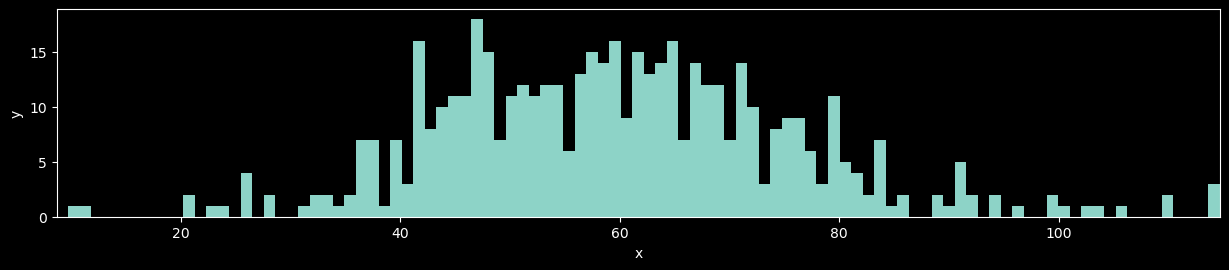

In [15]:
plt.style.use("dark_background")
plt.figure(figsize=(15,15))
plt.hist(masking_ratio_values,bins=100)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(min(masking_ratio_values)-1, max(masking_ratio_values))
# plt.ylim(0, 1000)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [14]:
import math

mean = np.mean(masking_ratio_values)
std = np.std(masking_ratio_values)
left_cutoff = math.ceil(mean - 2*std)
right_cutoff = math.ceil(mean + 2*std)

print(left_cutoff,right_cutoff)

28 92


In [16]:
indices = []
for i in range(len(YTRAIN)):    
    if masking_ratio_values[i]<=28 or masking_ratio_values[i]>=93:
        indices.append(i)
        
YTRAIN = np.delete(YTRAIN, indices, axis = 0)
XTRAIN = np.delete(XTRAIN, indices, axis = 0)

In [17]:
print(XTRAIN.shape)
YTRAIN = YTRAIN.astype(bool)

(474, 512, 512, 1)


In [18]:
PATCH_XTRAIN = []
PATCH_YTRAIN = []

for img in XTRAIN:
    PATCH_XTRAIN.extend(make_patch(img))
    
print("PATCH_XTRAIN DONE")

for mask in YTRAIN:
    PATCH_YTRAIN.extend(make_patch(mask))
    
print("PATCH_YTRAIN DONE")

PATCH_XTRAIN DONE
PATCH_YTRAIN DONE


In [19]:
PATCH_XTRAIN = np.array(PATCH_XTRAIN).reshape(-1,256,256,1)
PATCH_YTRAIN = np.array(PATCH_YTRAIN).reshape(-1,256,256,1)
print(PATCH_XTRAIN.shape)
print(PATCH_YTRAIN.shape)

(1896, 256, 256, 1)
(1896, 256, 256, 1)


In [20]:
PATCH_XTRAIN,PATCH_YTRAIN = sklearn.utils.shuffle(PATCH_XTRAIN,PATCH_YTRAIN)

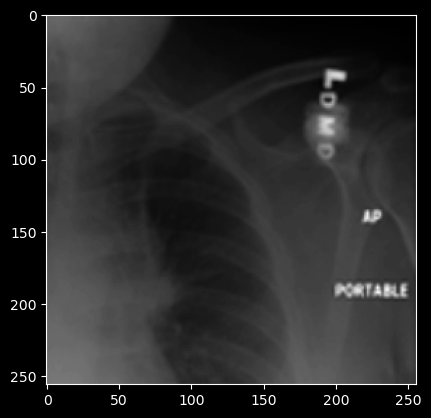

In [21]:
plt.imshow(PATCH_XTRAIN[1],cmap = 'gray')

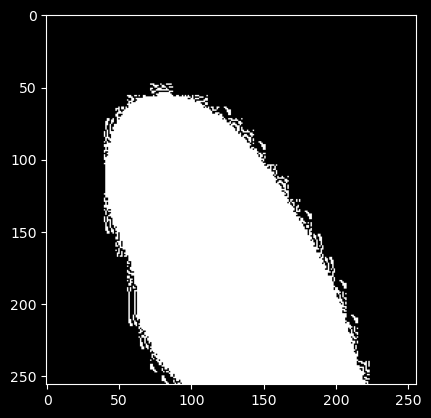

In [22]:
plt.imshow(PATCH_YTRAIN[1],cmap = 'gray')

In [ ]:
VAL_XTRAIN = []
VAL_YTRAIN = []

TRAIN_PARENT_PATH = os.path.join(DATA_DIR,SET[2])
VAL_TRAIN_IMG_PATH = TRAIN_PARENT_PATH + 'image/'
VAL_TRAIN_MASK_PATH = TRAIN_PARENT_PATH + 'mask/'

for img in os.listdir(VAL_TRAIN_IMG_PATH):
    IMG_PATH = os.path.join(VAL_TRAIN_IMG_PATH,img)
    img_array = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
    img_array.resize(256,256,1)
    VAL_XTRAIN.append(img_array)
        
for mask in os.listdir(VAL_TRAIN_MASK_PATH):
    MASK_PATH = os.path.join(VAL_TRAIN_MASK_PATH,mask)
    img_array = cv2.imread(MASK_PATH,cv2.IMREAD_GRAYSCALE)
    img_array.resize(256,256,1)
    VAL_YTRAIN.append(img_array)

In [ ]:
XTRAIN = np.array(XTRAIN).reshape(-1,256,256,1)
YTRAIN = np.array(YTRAIN).reshape(-1,256,256,1)

In [ ]:
plt.imshow(VAL_XTRAIN[0],cmap = 'gray')

In [ ]:
plt.imshow(VAL_YTRAIN[0],cmap = 'gray')

In [24]:
XTEST = []
YTEST = []

TEST_PARENT_PATH = os.path.join(DATA_DIR,SET[1])
TEST_IMG_PATH = TEST_PARENT_PATH + 'image/'
TEST_MASK_PATH = TEST_PARENT_PATH + 'mask/'
count = 0

for img in os.listdir(TEST_IMG_PATH):
    if count<1:
        IMG_PATH = os.path.join(TEST_IMG_PATH,img)
        img_array = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        XTEST.append(img_array)
        count += 1
print("XTEST DONE")
count = 0

for mask in os.listdir(TEST_MASK_PATH):
    if count<1:
        MASK_PATH = os.path.join(TEST_MASK_PATH,mask)
        img_array = cv2.imread(MASK_PATH,cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        YTEST.append(img_array)
        count += 1
        
print("YTEST done")

XTEST DONE
YTEST done


In [25]:
XTEST = np.array(XTEST).reshape(-1,512,512,1)/511
YTEST = np.array(YTEST).reshape(-1,512,512,1).astype(bool)
print("DONE")

DONE


In [26]:
masking_ratio_values = np.zeros(len(YTEST))
for i in range(len(YTEST)):
    masking_ratio_values[i] = masking_ratio(YTEST[i],[512,512])

In [ ]:
plt.style.use("dark_background")
plt.figure(figsize=(15,15))
plt.hist(masking_ratio_values,bins=100)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(min(masking_ratio_values)-1, max(masking_ratio_values))
# plt.ylim(0, 1000)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
XTRAIN.shape

In [27]:
PATCH_XTEST = []
PATCH_YTEST = []

for img in XTEST:
    PATCH_XTEST.extend(make_patch(img))
    
print("PATCH_XTEST DONE")

for mask in YTEST:
    PATCH_YTEST.extend(make_patch(mask))
    
print("PATCH_YTEST DONE")

PATCH_XTEST DONE
PATCH_YTEST DONE


In [28]:
PATCH_XTEST = np.array(PATCH_XTEST).reshape(-1,256,256,1)
PATCH_YTEST = np.array(PATCH_YTEST).reshape(-1,256,256,1)
print(PATCH_XTEST.shape)
print(PATCH_YTEST.shape)

(4, 256, 256, 1)
(4, 256, 256, 1)


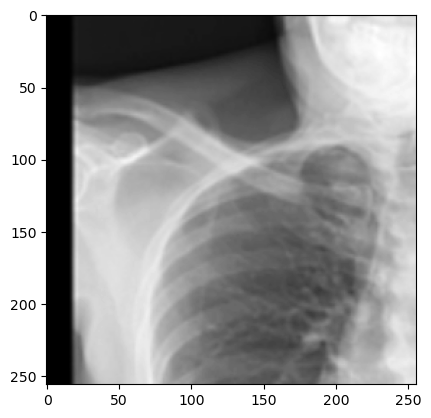

In [26]:
plt.imshow(PATCH_XTEST[0],cmap = 'gray')

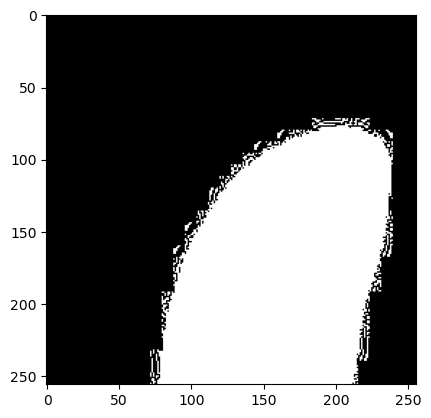

In [27]:
plt.imshow(PATCH_YTEST[0],cmap = 'gray')

In [21]:
from keras import backend as K

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
        
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def dice_coef(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice
    
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [22]:
# with strategy.scope():
model = multi_unet_model(IMG_SIZE = [256,256], IMG_CHANNELS = 1, N_CLASSES = 1 , activation_ = LearnableSwish() )
    
model.compile(
        optimizer = 'adam',
        loss = [dice_coef_loss],
        metrics = [iou]
        )
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  81          ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  585         ['dropout[0][0]']            

In [23]:
history = model.fit(PATCH_XTRAIN,PATCH_YTRAIN,batch_size = 96 ,validation_split = 0.33 ,epochs = 120)

Epoch 1/120
14/14 [==============================] - 39s 2s/step - loss: -0.3487 - iou: 0.2109 - val_loss: -0.3559 - val_iou: 0.2162
Epoch 2/120
14/14 [==============================] - 16s 1s/step - loss: -0.3946 - iou: 0.2493 - val_loss: -0.3830 - val_iou: 0.2365
Epoch 3/120
14/14 [==============================] - 16s 1s/step - loss: -0.4473 - iou: 0.2901 - val_loss: -0.4534 - val_iou: 0.2924
Epoch 4/120
14/14 [==============================] - 16s 1s/step - loss: -0.5209 - iou: 0.3574 - val_loss: -0.4967 - val_iou: 0.3294
Epoch 5/120
14/14 [==============================] - 16s 1s/step - loss: -0.5501 - iou: 0.3857 - val_loss: -0.5175 - val_iou: 0.3482
Epoch 6/120
14/14 [==============================] - 16s 1s/step - loss: -0.5707 - iou: 0.3973 - val_loss: -0.5213 - val_iou: 0.3524
Epoch 7/120
14/14 [==============================] - 16s 1s/step - loss: -0.5775 - iou: 0.4078 - val_loss: -0.4928 - val_iou: 0.3269
Epoch 8/120
14/14 [==============================] - 16s 1s/step - lo

In [29]:
yhat = model.predict(PATCH_XTEST)

1/1 [==============================] - 1s 722ms/step


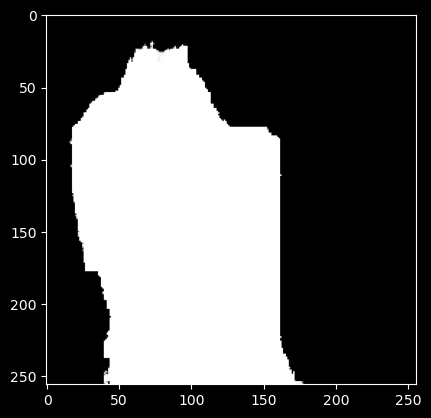

In [38]:
plt.imshow(yhat[1],cmap = 'gray')

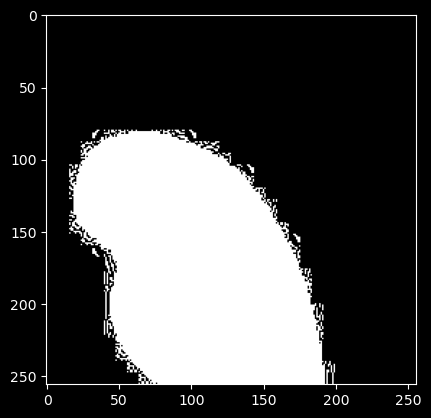

In [37]:
plt.imshow(PATCH_YTEST[1],cmap = 'gray')

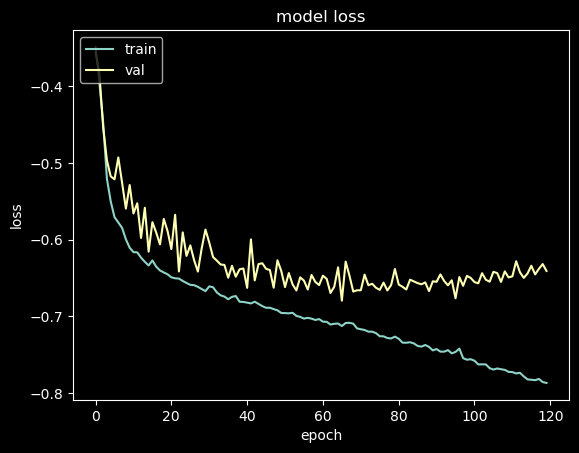

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

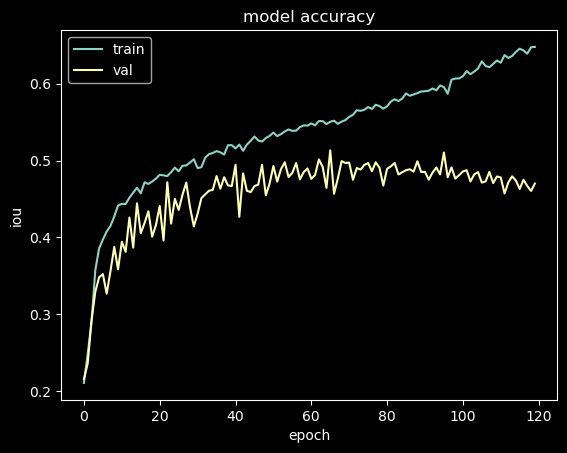

In [42]:
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('model accuracy')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()